# scikit-learn: Maskinlæring for 80% av behovene

Når folk snakker om maskinlæring nå for tiden snakker de ofte om avanserte metoder, primært dype nevrale nettverk. Men mesteparten av maskinlæringssystemer som lages er langt enklere, og veldig mye er vanlig regresjon som de fleste allerede kjenner. Scikit-learn inneholder masse funksjonalitet for å dekke de vanlige (og til tider litt uvanlige) behovene innne maskinlæring.

Regresjon, Support Vector Machines (SVM), Random Forest, Decision trees, KNN samt unsupervised metoder som K-means kan gjøres med scikit-learn, og det er dette som kommer til å være mest nyttig i arbeidsverdagen som data scientist.

Først ut er litt unsupervised learning, men med en vri. Heller enn å snakke om K-means og PCA, utforsker vi noen metoder for utliggerdeteksjon.

## Utliggerdeteksjon

Mange statistikker i SSB må fjerne utliggere, fordi de har for stor påvirkning på gjennomsnitt eller summer.

![Utliggerdeteksjon](./images/outlier.png "Utliggerdeteksjon")

Ofte ser vi kun på utliggere i én dimensjon og vi kan bruke f.eks. kvartilmetoden for å holde utenfor observasjoner som ligger for langt over eller under kvartilene, men det finnes også mer avanserte metoder som HB, som ser på både nivå og endring.

Det er mange som har behov for å finne ekstremobservasjoner, også utenfor statistikkbyrå. Scikit-learn har innebygget noen metoder for dette, og vi skal gå gjennom noen av disse.

Vi eksemplifiserer ved hjelp av lønnsdata fra Boston, et åpent tilgjengelig datasett som har visse likheter med norske lønnsdata.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [2]:
def force_to_float(f):
    try:
        rf = float(f.replace(",", ""))
    except:
        rf = 0
    return(rf)



import pandas as pd
emp = pd.read_csv('/data/kurs/python/payroll/employeeearningscy18full.csv', 
                  converters={'REGULAR': force_to_float, 
                              'RETRO': force_to_float, 
                              'OTHER': force_to_float, 
                              'OVERTIME': force_to_float,
                              'INJURED': force_to_float,
                              'DETAIL': force_to_float,
                              'QUINN/EDUCATION INCENTIVE': force_to_float,
                             'TOTAL EARNINGS': force_to_float},
                  encoding='latin1')

Her brukte vi et nytt argument til pandas, nemlig `converters`. Lønnstallene i filen er oppgitt med komma som tusenskilletegn, og vi må tvinge tallet til flyttall. Dette gjør vi med funksjonen `force_to_float`, som kjøres på de angitte kolonneverdiene som en del av innlesingen. Det finnes også andre måter å håndtere akkurat dette eksempelet på, men dette er en veldig nyttig og fleksibel opsjon.

In [3]:
testdf0 = emp[['REGULAR', 'OVERTIME']].sample(frac=0.1)

testdf = (testdf0 - testdf0.mean() ) / testdf0.std()

testdf.head()

,REGULAR,OVERTIME
8466,-1.039604,-0.364743
1735,1.032627,4.431983
4264,1.277719,-0.364743
12932,-0.504855,-0.364743
4633,0.845049,-0.364743


In [4]:
testdf.mean()

REGULAR     2.984242e-15
OVERTIME   -4.848758e-16
dtype: float64


Her ser vi flyttall in action - snittet skal pr def være 0, men grunnet avrunding er ikke resultatet helt nøyaktig. at tallet er av størrelsesorden e-16 er ikke en tilfeldighet: double-precision flyttall har en presisjon på 16 signifikante siffer.

In [5]:
testdf.std()

REGULAR     1.0
OVERTIME    1.0
dtype: float64

### Isolation forest
Denne metoden går i korthet ut på å finne observasjoner som ligger langt fra andre observasjoner, ved å tilfeldig splitte datasettet i deler - dette fungerer bra på data opp til 5-10 dimensjoner, men for tilstrekkelig høydimensjonale data vil "the curse of dimensionality" bli tydelig og metoden vil være mindre effektiv.

In [6]:
from sklearn.ensemble import IsolationForest

isoforest = IsolationForest(contamination=0.1,
                                         random_state=42, behaviour='new')

isoforest.fit(testdf)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [7]:
isoforest_status = isoforest.fit_predict(testdf)

In [8]:
isoforest_status[:10]

array([ 1, -1,  1,  1,  1,  1, -1,  1,  1, -1])

<Figure size 864x432 with 0 Axes>

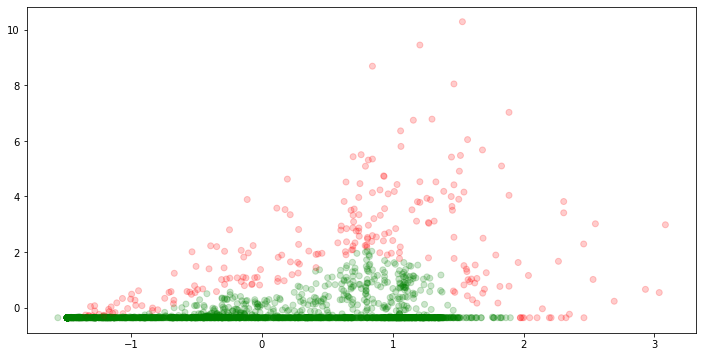

In [9]:

figure(num=None, figsize=(12, 6))

clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in isoforest_status]

figure(num=None, figsize=(12, 6))


plt.scatter( testdf['REGULAR'], testdf['OVERTIME'], c=cs, alpha=0.2 )

### Elliptic Envelope

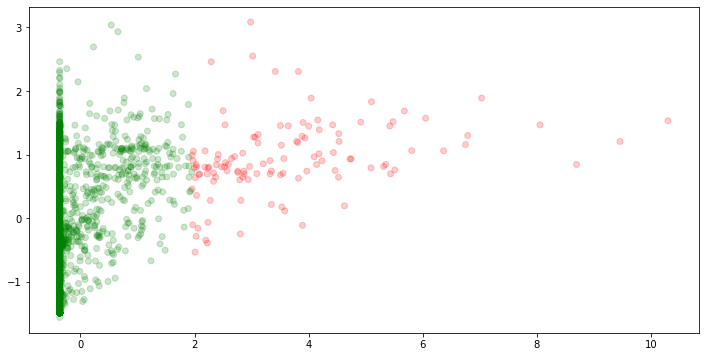

In [10]:
from sklearn.covariance import EllipticEnvelope

ellenv = EllipticEnvelope(contamination=0.05, support_fraction=0.75, ).fit(testdf)

ellenv_status = ellenv.fit_predict(testdf)

cs = [clrs[e] for e in ellenv_status]

figure(num=None, figsize=(12, 6))
plt.scatter( testdf['OVERTIME'], testdf['REGULAR'], c=cs, alpha=0.2 )

Her ser vi at skaleringen ikke har vært god nok, skalaen på x-aksen er lenger enn skalaen på y-aksen og vi får en veldig mekanisk cutoff omtrent på `overtime`>2

### Local outlier factor

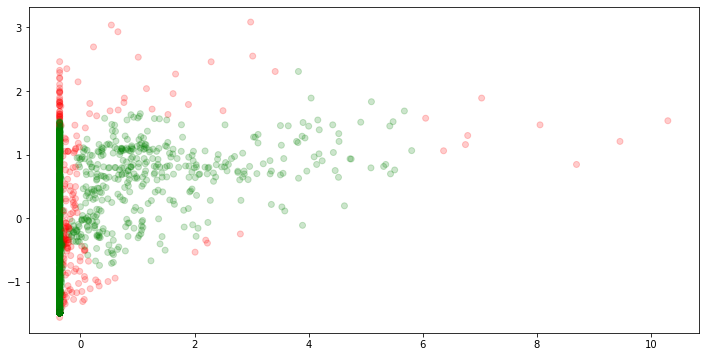

In [11]:
from sklearn.neighbors import LocalOutlierFactor

localout = LocalOutlierFactor(
        n_neighbors=35, contamination=0.1).fit(testdf)

localout_status = localout.fit_predict(testdf)

cs = [clrs[e] for e in localout_status]

figure(num=None, figsize=(12, 6))
plt.scatter( testdf['OVERTIME'], testdf['REGULAR'], c=cs, alpha=0.2 )

### OneClass SVM

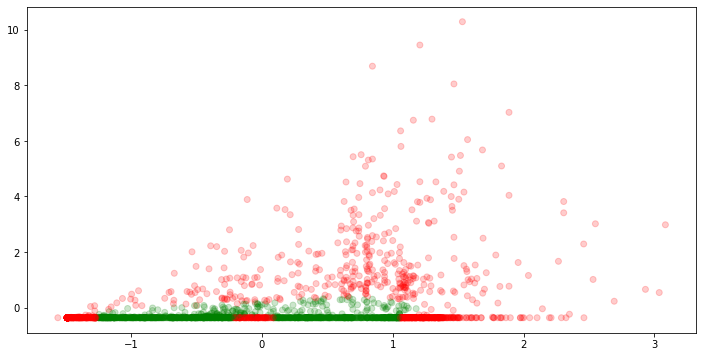

In [12]:
from sklearn.svm import OneClassSVM

outlier_svm = OneClassSVM(gamma='scale').fit( testdf )

oneclass_status = outlier_svm.fit_predict( testdf )

figure(num=None, figsize=(12, 6))

clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in oneclass_status]

plt.scatter(testdf['REGULAR'], testdf['OVERTIME'], c=cs, alpha=0.2 )

## Supervised learning: Aktivitetsprediksjon

Her bruker vi et datasett over aktiviteter, målt av smarttelefoner. Et team forskere målte smarttelefoners sensorer under ulike aktiviteter, for en gruppe testdeltagere. Dette er samlet i et datasett (trenings-/testdatasett) som kan brukes for å estimere aktivitet basert på sensordataene.

Siden det er flere (6) aktiviteter, trenger vi å bruke multiclass prediksjon.

En morsomhet her er at testdataene ikke bare er tilfeldige rader fra datasettet, men egne testpersoner som ikke inngår i treningsdatasettet.

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
import xgboost as xgb

df_train = shuffle(pd.read_csv('/data/kurs/python/human-activity-recognition-with-smartphones/train.csv'))
df_test = shuffle(pd.read_csv('/data/kurs/python/human-activity-recognition-with-smartphones/test.csv'))

### Datatilrettelegging

Som alltid er det datatilrettelegging som tar mest tid, selv nå hvor datasettet er veldig godt tilrettelagt fra før. Vi begynner med å ta en liten titt på data, og `Activity`-kolonnen som vi skal predikere. SVM takler ikke tekstkolonner

In [14]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
3823,0.276133,0.036186,-0.018658,-0.985290,-0.851795,-0.938676,-0.985278,-0.841877,-0.937344,-0.928335,...,0.117328,0.050933,-0.044539,0.148014,-0.685195,-0.812702,0.216336,-0.036979,19,STANDING
1395,0.268911,-0.013646,-0.111873,-0.969909,-0.958952,-0.977013,-0.969177,-0.967090,-0.974883,-0.920885,...,-0.620696,0.179251,0.033354,0.027036,-0.058407,0.583807,-0.063016,-0.961279,7,LAYING
6279,0.272190,-0.024906,-0.116681,-0.961089,-0.697802,-0.852264,-0.967275,-0.696201,-0.843646,-0.893756,...,-0.678007,0.032658,0.016837,-0.621771,0.588930,-0.793723,0.240170,0.030668,28,STANDING
3456,0.257836,-0.034016,-0.134666,-0.997491,-0.983542,-0.983969,-0.997515,-0.983555,-0.983108,-0.950454,...,-0.934131,0.007840,0.079411,-0.405458,0.373139,-0.650338,0.326737,0.096342,17,STANDING
6324,0.278818,-0.012661,-0.123502,-0.991439,-0.966023,-0.979588,-0.992595,-0.969079,-0.980895,-0.929471,...,-0.799540,-0.004790,-0.237604,0.449575,-0.172931,-0.777269,0.244475,0.067040,28,SITTING


In [15]:
df_train['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [16]:
X_train = df_train.drop(['Activity', 'subject'], axis=1).values
X_test = df_test.drop(['Activity', 'subject'], axis=1).values

y_train = df_train['Activity'].values
y_test = df_test['Activity'].values

In [17]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [18]:
y_train_encoded.shape

(7352,)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### SVM-basert prediksjon

Vi begynner med en SVM-modell for klassifisering. 

In [20]:
svm = SVC().fit(X_train_scaled, y_train_encoded)

In [21]:
y_pred = svm.predict(X_test_scaled)
sum(y_test_encoded==y_pred)/len(y_pred)

0.9562266711910418

In [22]:
y_pred[:10]

array([4, 0, 3, 0, 4, 2, 3, 2, 5, 2])

In [23]:
encoder.inverse_transform(y_pred[:10])

array(['WALKING_DOWNSTAIRS', 'LAYING', 'WALKING', 'LAYING',
       'WALKING_DOWNSTAIRS', 'STANDING', 'WALKING', 'STANDING',
       'WALKING_UPSTAIRS', 'STANDING'], dtype=object)

### XGBoost

XGBoost gjør det normalt veldig bra på tabulære data, og varianter av XGBoost kan brukes både med klassifikasjonsproblem og lineær output. Dette eksempelet bruker klassifisering.

XGBoost ligner på random forest i at data partisjoneres, men i hver av partisjonene brukes så regresjon for å predikere Y.

In [24]:
xgmodel = xgb.XGBClassifier().fit(X_train_scaled, y_train_encoded)
xgbpred = xgmodel.predict(X_test_scaled)


sum(y_test_encoded==xgbpred)/len(xgbpred)

0.9314557176789956

In [25]:
encoder.inverse_transform(xgbpred[:10])

array(['WALKING_DOWNSTAIRS', 'LAYING', 'WALKING', 'LAYING',
       'WALKING_DOWNSTAIRS', 'STANDING', 'WALKING', 'STANDING',
       'WALKING_UPSTAIRS', 'STANDING'], dtype=object)